In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

RANDOM_STATE = 17

In [2]:
X_train = np.loadtxt('data/UCI_HAR_Dataset/X_train.txt')
y_train = np.loadtxt('data/UCI_HAR_Dataset/y_train.txt').astype(int)

X_test = np.loadtxt('data/UCI_HAR_Dataset/X_test.txt')
y_test = np.loadtxt('data/UCI_HAR_Dataset/y_test.txt').astype(int)

In [3]:
assert X_train.shape == (7352, 561) and y_train.shape == (7352,)
assert X_test.shape == (2947, 561) and y_test.shape == (2947,)

In [4]:
X = np.concatenate((X_train, X_test))
y = np.concatenate((y_train, y_test))

In [5]:
X.shape, y.shape

((10299, 561), (10299,))

In [6]:
n_classes = np.unique(y).size
n_classes

6

In [7]:
# 1 – walking

# 2 – walking upstairs

# 3 – walking downstairs

# 4 – sitting

# 5 – standing

# 6 – laying down

In [8]:
stsc = StandardScaler()

In [9]:
X = stsc.fit_transform(X)

In [10]:
pca = PCA(0.9, random_state=RANDOM_STATE)

In [11]:
X_pca = pca.fit_transform(X)

In [12]:
X_pca.shape, pca.explained_variance_ratio_[0]

((10299, 65), 0.5073822103501331)

In [13]:
# Question 1: What is the minimum number of principal components required to cover the 90% 
# of the variance of the original (scaled) data?
# Answer: 65

# Question 2: What percentage of the variance is covered by the first principal component? Round to the nearest percent.
# Answer: 51

In [14]:
X_pca.shape, y.shape

((10299, 65), (10299,))

In [15]:
X_pca[:, 0]

array([-16.38097982, -15.58217328, -15.42398918, ...,  11.84685312,
         8.20668637,   9.31117251])

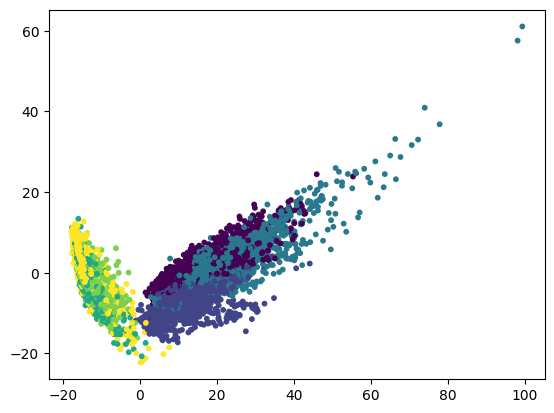

In [16]:
plt.scatter(x=X_pca[:, 0], y=X_pca[:, 1], c=y, s=10, cmap='viridis');

In [17]:
# Question 3: If everything worked out correctly, you will see a number of clusters, 
# almost perfectly separated from each other. What types of activity are included in these clusters?

# Answer: 2 clusters: (walking, walking upstairs, walking downstairs ) and (sitting, standing, laying)

In [18]:
kmn = KMeans(n_clusters=6, n_init=100, random_state=RANDOM_STATE)

In [19]:
y_kmn = kmn.fit_predict(X_pca)

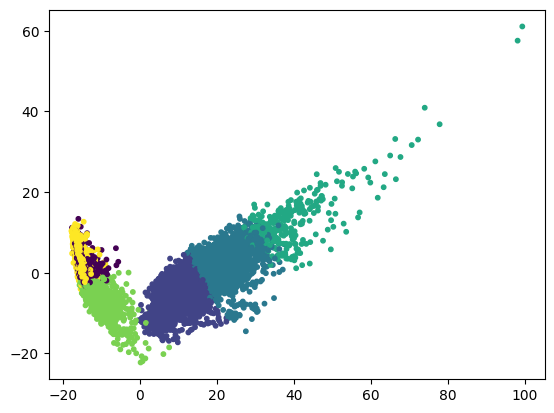

In [20]:
plt.scatter(x=X_pca[:, 0], y=X_pca[:, 1], c=y_kmn, s=10, cmap='viridis');

In [21]:
tab = pd.crosstab(y, y_kmn, margins=True)
tab.index = ['walking', 'going up the stairs',
            'going down the stairs', 'sitting', 'standing', 'laying', 'all']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['all']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,all
walking,0,903,741,78,0,0,1722
going up the stairs,0,1241,296,5,2,0,1544
going down the stairs,0,320,890,196,0,0,1406
sitting,1235,1,0,0,450,91,1777
standing,1344,0,0,0,562,0,1906
laying,52,5,0,0,329,1558,1944
all,2631,2470,1927,279,1343,1649,10299


In [22]:
# Question 4: Which activity is separated from the rest better than others based on the simple metric described above?
# Answer: laying

In [23]:
inertia = []
for k in tqdm(range(1, n_classes + 1)):
    kmn = KMeans(n_clusters=k, n_init=100, random_state=RANDOM_STATE)
    kmn.fit(X_pca)
    inertia.append(np.sqrt(kmn.inertia_))

  0%|          | 0/6 [00:00<?, ?it/s]

In [24]:
inertia

[2280.9554317530883,
 1642.536683983004,
 1531.8045255008424,
 1485.6418878723343,
 1442.5619962175456,
 1415.434526891236]

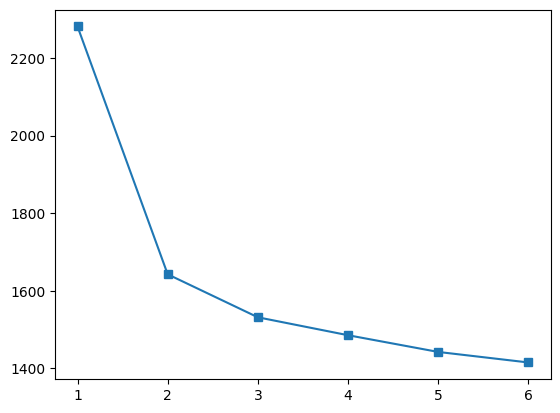

In [25]:
plt.plot(range(1, n_classes + 1), inertia, marker="s");

In [26]:
d = {}
for k in range(2, n_classes):
    i = k - 1
    d[k] = (inertia[i] - inertia[i + 1]) / (inertia[i - 1] - inertia[i])

In [27]:
d

{2: 0.1734475356009437,
 3: 0.4168855575586437,
 4: 0.9332198909748711,
 5: 0.6297014287707519}

In [28]:
# Question 5: How many clusters can we choose according to the elbow method?

# Answer: 2

In [29]:
ag = AgglomerativeClustering(n_clusters=n_classes,
                              linkage='ward').fit(X_pca)

In [30]:
print(adjusted_rand_score(labels_true=y, labels_pred=ag.labels_))

for k in tqdm(range(1, n_classes + 1)):
    kmn = KMeans(n_clusters=k, n_init=100, random_state=RANDOM_STATE)
    kmn.fit(X_pca)
    print(adjusted_rand_score(labels_true=y, labels_pred=kmn.labels_))

0.49362763373004886


  0%|          | 0/6 [00:00<?, ?it/s]

0.0
0.3296106738894193
0.3318296726527975
0.29889441463067856
0.29124577268033486
0.4198070012602345


In [31]:
# Question 6: Select all the correct statements.

# Answer: 
# According to ARI, KMeans handled clustering worse than Agglomerative Clustering
# For ARI, it does not matter which tags are assigned to the cluster, only the partitioning of instances into clusters matters
# In case of random partitioning into clusters, ARI will be close to zero

In [32]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled =scaler.fit_transform(X_test)

In [33]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {"C": [0.001, 0.01, 0.1, 1, 10]}

In [34]:
grid_search = GridSearchCV(estimator=svc, param_grid=svc_params, n_jobs=-1, cv=3)
grid_search.fit(X_train_scaled, y_train)

C:\Python\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Python\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


GridSearchCV(cv=3, estimator=LinearSVC(random_state=17), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]})

In [35]:
best_svc = grid_search.best_estimator_

In [36]:
grid_search.best_params_, grid_search.best_score_

({'C': 0.1}, 0.9382506099134881)

In [37]:
# Question 7: Which value of the hyperparameter C was chosen the best on the basis of cross-validation?
# Answer: 0.1

In [38]:
y_predicted = best_svc.predict(X_test_scaled)

In [39]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['walking', 'climbing up the stairs',
             'going down the stairs', 'sitting', 'standing', 'laying', 'all']
tab.columns = ['walking', 'climbing up the stairs',
             'going down the stairs', 'sitting', 'standing', 'laying', 'all']
tab

,walking,climbing up the stairs,going down the stairs,sitting,standing,laying,all
walking,479,11,4,2,0,0,496
climbing up the stairs,4,465,1,1,0,0,471
going down the stairs,1,2,416,1,0,0,420
sitting,0,4,0,433,52,2,491
standing,0,0,0,16,516,0,532
laying,0,0,0,0,6,531,537
all,484,482,421,453,574,533,2947


In [40]:
# Question 8: Which activity type is worst detected by SVM in terms of precision? Recall?
# Answer: precision – standing, recall – sitting

In [41]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [42]:
X_train_scaled_pca = pca.fit_transform(X_train_scaled)
X_test_scaled_pca = pca.fit_transform(X_test_scaled)

In [43]:

grid_search = GridSearchCV(estimator=svc, param_grid=svc_params, n_jobs=-1, cv=3)
grid_search.fit(X_train_scaled_pca, y_train)

C:\Python\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Python\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


GridSearchCV(cv=3, estimator=LinearSVC(random_state=17), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]})

In [44]:
best_svc = grid_search.best_estimator_
grid_search.best_params_, grid_search.best_score_

({'C': 1}, 0.8998943094169531)

In [45]:
# Question 9: What is the difference between the best quality (accuracy) 
# for cross-validation in the case of all 561 initial characteristics and in the second case, 
# when the principal component method was applied? Round to the nearest percent.

# Answer 4%

In [46]:
# Question 10: Select all the correct statements:

# Principal component analysis in this case allowed to reduce the model training time, 
# while the quality (mean cross-validation accuracy) suffered greatly, by more than 10%

# PCA can be used to visualize data, but there are better methods for this task, for example, tSNE. 
# However, PCA has lower computational complexity

# PCA builds linear combinations of initial features, and in some applications they might be poorly interpreted by humans

# Answer: 2, 3